In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import datetime
import astropy.units as u
from astropy.coordinates import Angle, EarthLocation, SkyCoord, AltAz
from astropy.time import Time
from satellite_tle import fetch_tle_from_celestrak
from pandas import date_range
from skyfield.api import EarthSatellite, load, wgs84
eph = load('de421.bsp') # Ephemerides of the planets and satellites in the solar system

import win32com.client

# Compute the trajectory of the satellite during next pass

Setting up the observatory

In [2]:
# Observatory location
latitude = 46.5185794
longitude = 6.5666111
elevation = 100

obs = wgs84.latlon(latitude, longitude, elevation)

print("Calculations for Observer at:")
print(f" Longitude: {obs.longitude}")
print(f" Latitude: {obs.latitude}")
print(f" Elevation: {obs.elevation.to(u.m)}")

Calculations for Observer at:
 Longitude: 06deg 33' 59.8"
 Latitude: 46deg 31' 06.9"
 Elevation: 100.0 m


Downloading TLE data from Celestrack for the targeted satellite

In [3]:
# Download TLE data from Celestrak
norad_id = 25544 # ISS (ZARYA)
# norad_id = 42749 # ECHOSTAR 21 (GEO satellite)
# norad_id = 54743 # METEOSAT 21 (MTG-I1)
tle = fetch_tle_from_celestrak(norad_id)
sat = EarthSatellite(tle[1], tle[2], tle[0])
print(f"Epoch of TLE: {sat.epoch.utc_iso()}")

Epoch of TLE: 2024-10-15T16:17:58Z


Calculate the next passes of the satellite over the observatory

In [4]:
# Define time span to search for next satellite passes
ts = load.timescale()
t0 = ts.now() # Current time
t1 = t0 + datetime.timedelta(days=3) # Next day

In [5]:
# Calculate next satellite passes above a certain elevation
min_altitude = 50.0
t_events, events = sat.find_events(obs, t0, t1, altitude_degrees=min_altitude)

In [6]:
# Display passes
event_names = f'rise above {min_altitude}°', 'culminate', f'set below {min_altitude}°'
for ti, event in zip(t_events, events):
    event_name = event_names[event]
    if event == 1: # Culminate
        alt, az, dist = (sat-obs).at(ti).altaz()
        sunlit = sat.at(ti).is_sunlit(eph)
        event_name = f"{event_name} at {alt.degrees:.1f}° {'(sunlit)' if sunlit else '(eclipsed)'}"
    print(f"{ti.utc_iso()} {event_name}")
    if event == 2: # Set
        print("-"*50)

2024-10-16T10:50:40Z rise above 50.0°
2024-10-16T10:51:23Z culminate at 72.8° (sunlit)
2024-10-16T10:52:06Z set below 50.0°
--------------------------------------------------
2024-10-17T06:48:11Z rise above 50.0°
2024-10-17T06:48:40Z culminate at 57.4° (sunlit)
2024-10-17T06:49:10Z set below 50.0°
--------------------------------------------------
2024-10-17T10:02:41Z rise above 50.0°
2024-10-17T10:03:00Z culminate at 52.6° (sunlit)
2024-10-17T10:03:19Z set below 50.0°
--------------------------------------------------
2024-10-18T05:59:31Z rise above 50.0°
2024-10-18T06:00:16Z culminate at 80.8° (sunlit)
2024-10-18T06:01:02Z set below 50.0°
--------------------------------------------------
2024-10-18T10:51:06Z rise above 50.0°
2024-10-18T10:51:22Z culminate at 52.0° (sunlit)
2024-10-18T10:51:39Z set below 50.0°
--------------------------------------------------


Calculate the position of the satellite during next pass

In [7]:
# Calculate satellite position during pass
pass_number = 0
t0 = t_events[3*pass_number+1] - datetime.timedelta(minutes=3)
t1 = t_events[3*pass_number+1] + datetime.timedelta(minutes=3)
t_pass = ts.from_datetimes(date_range(t0.utc_iso(), t1.utc_iso(), freq='100ms'))

topocentric_pos = (sat-obs).at(t_pass)
alt, az, dist = topocentric_pos.altaz()
ra, dec, dist = topocentric_pos.radec()

Plot the trajectory in the sky of the next satellite pass

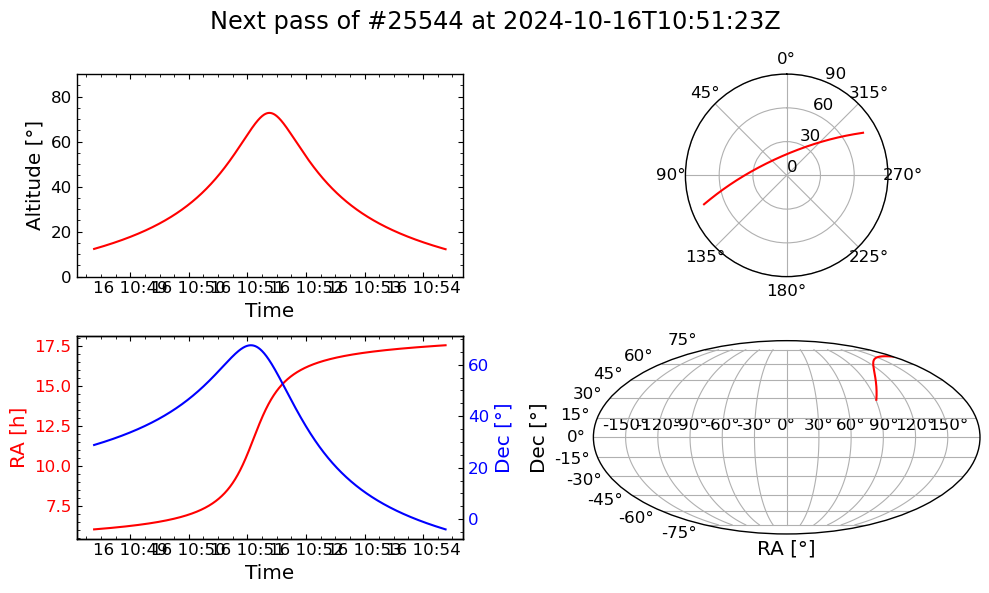

In [8]:
fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(221)
ax.plot_date(t_pass.utc_datetime(), alt.degrees, 'r-')
ax.set_ylim(0, 90)
ax.set_xlabel('Time')
ax.set_ylabel('Altitude [°]')

ax = fig.add_subplot(222, projection='polar')
ax.plot(az.radians, 90-alt.degrees, 'r-')
ax.set_theta_zero_location('N')
ax.set_rticks([0, 30, 60, 90])
ax.set_rlabel_position(-22.5)
ax.grid(True)

ax = fig.add_subplot(223)
ax.plot_date(t_pass.utc_datetime(), ra.hours, 'r-')
ax.tick_params(axis='y', labelcolor='r')
ax.set_ylabel('RA [h]', color='r')
ax.set_xlabel('Time')
ax2 = ax.twinx()
ax2.plot_date(t_pass.utc_datetime(), dec.degrees, 'b-')
ax2.tick_params(axis='y', labelcolor='b')
ax2.set_ylabel('Dec [°]', color='b')

ax = fig.add_subplot(224, projection='mollweide')
ax.plot(ra.radians, dec.radians, 'r-')
ax.set_xlabel('RA [°]')
ax.set_ylabel('Dec [°]')
ax.grid(True)

fig.suptitle(f"Next pass of #{sat.model.satnum} at {t_pass[len(t_pass)//2].utc_iso()}")
fig.tight_layout()
plt.show()

# Track satellite with mount based on TLE

### Calculate RaDec coordinates from AltAz at a different time

In [9]:
# Add a time offset for simulation

# time_offset = 0 # Time of pass
time_offset = t_pass[0].utc_datetime() - datetime.datetime.now(datetime.timezone.utc) # Current time

obstime = (t_pass - time_offset).utc_datetime()

track_ra = ((ra.hours-time_offset.total_seconds()/3600)%24)*u.hourangle
track_dec = dec.degrees*u.deg

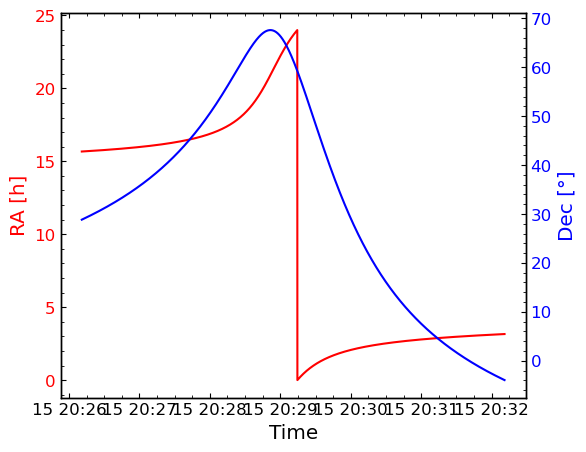

In [10]:
fig, ax = plt.subplots()

ax.plot_date(obstime, track_ra.to_value(u.hourangle), 'r-')
ax.tick_params(axis='y', labelcolor='r')
ax.set_ylabel('RA [h]', color='r')
ax.set_xlabel('Time')

ax2 = ax.twinx()
ax2.plot_date(obstime, track_dec.to_value(u.deg), 'b-')
ax2.tick_params(axis='y', labelcolor='b')
ax2.set_ylabel('Dec [°]', color='b')

plt.show()

### Move telescope

Connect to the telescope mount

In [11]:
tel = win32com.client.Dispatch("EQMOD_SIM.Telescope")
# tel = win32com.client.Dispatch("EQMOD.Telescope")

print("Chosen driver:",tel)

Chosen driver: <COMObject EQMOD_SIM.Telescope>


In [12]:
# Connect to the telescope
if tel.Connected:
    print("	->Telescope was already connected")
else:
    tel.Connected = True
    if tel.Connected:
        print("	Connected to telescope now")
    else:
        print("	Unable to connect to telescope, expect exception")

	Connected to telescope now


Move the telescope to the start point, at a given elevation

In [53]:
# Unpark and move telescope to start point
tel.Unpark()
initial_alt = 30
initial_ra = track_ra[alt.degrees>initial_alt][0].to_value(u.hourangle)
initial_dec = track_dec[alt.degrees>initial_alt][0].to_value(u.deg)
print(f"Initial position: RA={Angle(initial_ra*u.hour).to_string(unit=u.hour, precision=2)}, Dec={Angle(initial_dec*u.degree).to_string(unit=u.degree, precision=2)}")
tel.SlewToCoordinatesAsync(initial_ra, initial_dec)

Initial position: RA=16h28m29.40s, Dec=44d52m33.27s


In [54]:
while tel.Slewing:
    time.sleep(1)

Track the targeted satellite by commanding the mount in RaDec

In [55]:
real_ra, real_dec = [], []
cmd_ra, cmd_dec = [], []
T = []

Kp = 0.
rate_ra_max = tel.AxisRates(0)[0].Item(1).Maximum
rate_dec_max = tel.AxisRates(1)[0].Item(1).Maximum
dt = (obstime[1]-obstime[0]).total_seconds()
t = datetime.datetime.now(datetime.timezone.utc)
offset = obstime[alt.degrees>initial_alt][0] - t
index = np.where(t+offset < obstime)[0][0]
while t+offset < obstime[np.where(alt.degrees>60)[0][-1]]:
    try:
        # Find index of current time
        t = datetime.datetime.now(datetime.timezone.utc)
        index = np.where(t+offset < obstime)[0][0]
        # Log data
        T.append(t)
        cmd_ra.append(track_ra[index].to_value(u.hourangle))
        cmd_dec.append(track_dec[index].to_value(u.deg))
        real_ra.append(tel.RightAscension)
        real_dec.append(tel.Declination)
        p_ra = (track_ra[index+1]-track_ra[index]).to_value(u.deg)/dt
        p_dec = (track_dec[index+1]-track_dec[index]).to_value(u.deg)/dt
        err_ra = cmd_ra[-1] - real_ra[-1]
        err_dec = cmd_dec[-1] - real_dec[-1]
        # Slew to next position
        if abs(err_ra) > 1 or abs(err_dec) > 1:
            print("Out of tracking")
            tel.SlewToCoordinatesAsync(cmd_ra[-1], cmd_dec[-1])
        else:
            ra_rate = np.clip(-p_ra + Kp*err_ra, -0.9*rate_ra_max, 0.9*rate_ra_max)
            dec_rate = np.clip(-p_dec + Kp*err_dec, -0.9*rate_dec_max, 0.9*rate_dec_max)
            tel.MoveAxis(0, ra_rate)
            tel.MoveAxis(1, dec_rate)
        time.sleep(0.5)
    except:
        print("Error")
        break
tel.MoveAxis(0, 0)
tel.MoveAxis(1, 0)

Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of tracking
Out of t

(1, 0.0)

Plot the actual RaDec position versus the command

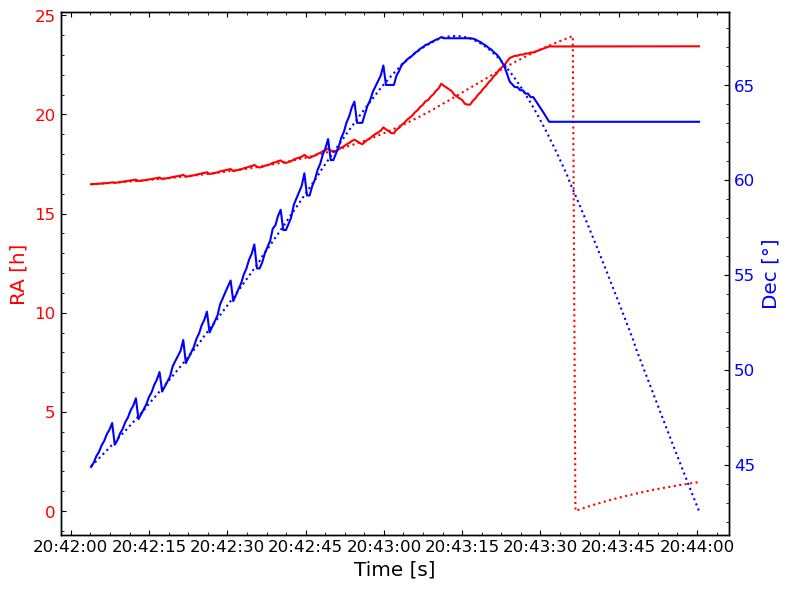

In [56]:
# Plot RaDec
fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.plot(T, cmd_ra, 'r:', label='Commanded RA')
ax.plot(T, real_ra, 'r-', label='Real RA')
ax.set_ylabel('RA [h]', color='r')
ax.tick_params(axis='y', labelcolor='r')
ax.set_xlabel('Time [s]')

ax2 = ax.twinx()
ax2.plot(T, cmd_dec, 'b:', label='Commanded Dec')
ax2.plot(T, real_dec, 'b-', label='Real Dec')
ax2.set_ylabel('Dec [°]', color='b')
ax2.tick_params(axis='y', labelcolor='b')

fig.tight_layout()
plt.show()

Plot the actual AltAz vs the command

In [57]:
# Calculate AltAz from RaDec
obs_astropy = EarthLocation(lat=obs.latitude.degrees*u.deg, lon=obs.longitude.degrees*u.deg, height=obs.elevation.m*u.m)
real_radec = SkyCoord(ra=real_ra*u.hourangle, dec=real_dec*u.deg, frame='icrs', obstime=Time(T), location=obs_astropy)
cmd_radec = SkyCoord(ra=cmd_ra*u.hourangle, dec=cmd_dec*u.deg, frame='icrs', obstime=Time(T), location=obs_astropy)
real_altaz = real_radec.transform_to('altaz')
cmd_altaz = cmd_radec.transform_to('altaz')

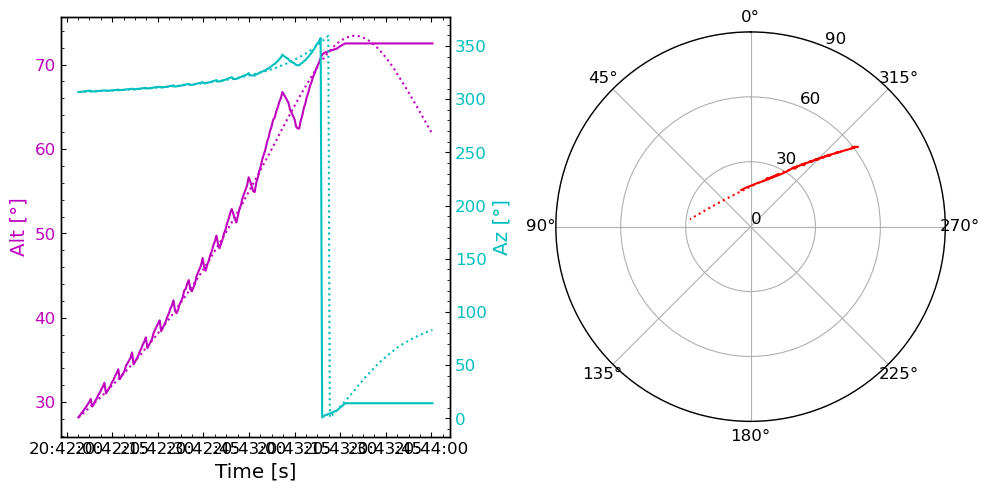

In [58]:
# Plot AltAz
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(121)
ax.plot(T, real_altaz.alt.to_value(u.deg), 'm-', label='Real Alt')
ax.plot(T, cmd_altaz.alt.to_value(u.deg), 'm:', label='Real Alt')
ax.set_ylabel('Alt [°]', color='m')
ax.tick_params(axis='y', labelcolor='m')
ax.set_xlabel('Time [s]')
ax2 = ax.twinx()
ax2.plot(T, real_altaz.az.to_value(u.deg), 'c-', label='Real Az')
ax2.plot(T, cmd_altaz.az.to_value(u.deg), 'c:', label='Real Az')
ax2.set_ylabel('Az [°]', color='c')
ax2.tick_params(axis='y', labelcolor='c')

ax = fig.add_subplot(122, projection='polar')
ax.plot(real_altaz.az.to_value(u.rad), 90-real_altaz.alt.to_value(u.deg), 'r-')
ax.plot(cmd_altaz.az.to_value(u.rad), 90-cmd_altaz.alt.to_value(u.deg), 'r:')
ax.set_theta_zero_location('N')
ax.set_rticks([0, 30, 60, 90])
ax.set_rlabel_position(-22.5)
ax.grid(True)

fig.tight_layout()
plt.show()

In [59]:
# Disconnect from the telescope
tel.Connected = False